In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn
seaborn.set()

import wrds
WRDS_LOGIN = 'cssmyth'

In [2]:
conn = wrds.Connection(wrds_username=WRDS_LOGIN)

Loading library list...
Done


In [3]:
wrds_names_query = conn.get_table(library='crsp', table='wrds_names_query') # get v2 table, which has secinfostartdt and enddt 

In [4]:
msf = conn.get_table(library='crsp', table='msf') # msf table, which has firm weights

In [16]:
# compute weight for all CRSP securities per month
msf['mktcap'] = msf['prc'].abs() * msf['shrout']
msf['total_mktcap'] = msf.groupby('date')['mktcap'].transform('sum')
msf['weight'] = msf['mktcap'] / msf['total_mktcap']

msf['pctile'] = (
    msf.groupby('date')['weight'].rank(pct=True, ascending=False)
)

In [17]:
msf.groupby('date').size().describe()

count    1189.000000
mean     4334.535744
std      3146.581845
min       520.000000
25%      1015.000000
50%      5163.000000
75%      7107.000000
max      9880.000000
dtype: float64

In [18]:
# make date a datetime type

msf['date'] = pd.to_datetime(msf['date'])
wrds_names_query['securitybegdt'] = pd.to_datetime(wrds_names_query['securitybegdt'])
wrds_names_query['securityenddt'] = pd.to_datetime(wrds_names_query['securityenddt'])

# turn dates into month period for joins

msf['month']  = msf['date'].dt.to_period('M')
wrds_names_query['beg_month'] = wrds_names_query['securitybegdt'].dt.to_period('M')
wrds_names_query['end_month'] = wrds_names_query['securityenddt'].dt.to_period('M')

In [19]:
# first and last month in msf universe
first_month = msf['month'].min()
last_month  = msf['month'].max()

# entrances 
df_ent = pd.merge(
    msf[['permno','month','pctile','weight','mktcap','total_mktcap']],
    wrds_names_query[['permno','beg_month']],
    left_on  = ['permno','month'],
    right_on = ['permno','beg_month'],
    how      = 'inner'
)
df_ent['event'] = 'entrance'
df_ent = df_ent[df_ent['month'] != first_month]

drop_months = [
    pd.Period('1962-07', 'M'),
    pd.Period('1972-12', 'M'),
    pd.Period('2006-03', 'M'),
]
df_ent = df_ent[~df_ent['month'].isin(drop_months)]

# exits 
df_exit = pd.merge(
    msf[['permno','month','pctile','weight','mktcap','total_mktcap']],
    wrds_names_query[['permno','end_month']],
    left_on  = ['permno','month'],
    right_on = ['permno','end_month'],
    how      = 'inner'
)
df_exit['event'] = 'exit'
df_exit = df_exit[df_exit['month'] != last_month]
df_exit = df_exit[~df_exit['month'].isin(drop_months)]
# collapse to one entrance (earliest) and exit (latest) per permno
df_ent = (df_ent
          .sort_values('month')                    
          .drop_duplicates(subset='permno',     
                           keep='first')          
         )
df_exit = (df_exit
           .sort_values('month')                   
           .drop_duplicates(subset='permno',     
                            keep='last')          
          )

# combine
df_events = pd.concat([df_ent, df_exit], ignore_index=True)

# rename if downstream expects quantile but p sure it doesn't
df_events.rename(columns={'pctile':'quantile'}, inplace=True)

In [20]:
df_exit

,permno,month,pctile,weight,mktcap,total_mktcap,end_month,event
5281,10997,1926-02,<NA>,<NA>,<NA>,26805585.625,1926-02,exit
24905,15309,1926-03,<NA>,<NA>,<NA>,25135468.1875,1926-03,exit
16846,13514,1926-03,<NA>,<NA>,<NA>,25135468.1875,1926-03,exit
15014,13020,1926-03,1.0,0.0,2.5,25135468.1875,1926-03,exit
8504,11615,1926-05,<NA>,<NA>,<NA>,26242695.5625,1926-05,exit
...,...,...,...,...,...,...,...,...
60516,24444,2024-11,<NA>,<NA>,<NA>,78525952865.008484,2024-11,exit
53468,22573,2024-11,<NA>,<NA>,<NA>,78525952865.008484,2024-11,exit
53472,22574,2024-11,<NA>,<NA>,<NA>,78525952865.008484,2024-11,exit
53413,22563,2024-11,<NA>,<NA>,<NA>,78525952865.008484,2024-11,exit


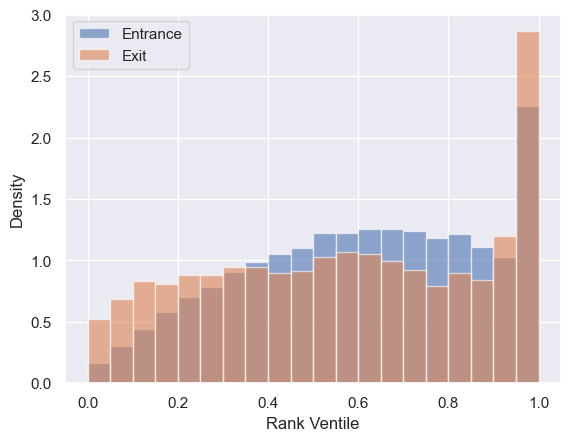

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pathlib import Path

# quantile histograms (decile bins)
decile_bins = np.linspace(0, 1, 21)
ent_q = df_events[df_events['event']=='entrance']['quantile']
exit_q = df_events[df_events['event']=='exit']['quantile']

plt.hist(ent_q, bins=decile_bins, alpha=0.6, label='Entrance', density=True)
plt.hist(exit_q, bins=decile_bins, alpha=0.6, label='Exit', density=True)
#plt.hist(ent_q, bins=decile_bins, alpha=0.6, label='Entrance')
#plt.hist(exit_q, bins=decile_bins, alpha=0.6, label='Exit')
plt.xlabel('Rank Ventile')
plt.ylabel('Density')
plt.legend()

out_dir = Path("images")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "ventiles.pdf"

#plt.title('Entrance vs Exit Quantiles')
plt.savefig(out_path, bbox_inches="tight")
plt.show()

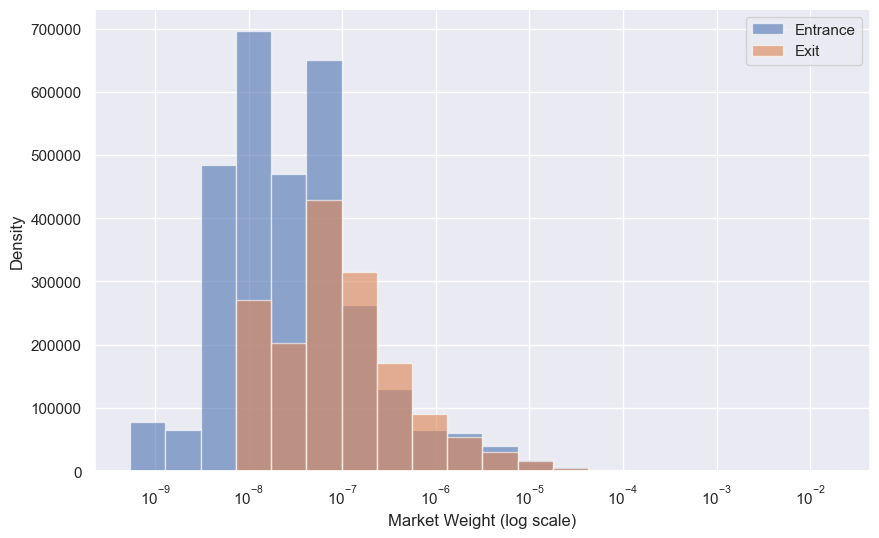

In [22]:
# extract the weight series for entrance and exit
weights_ent = df_events.loc[df_events['event']=='entrance', 'weight']
weights_exit = df_events.loc[df_events['event']=='exit', 'weight']

pos_ent = weights_ent[weights_ent > 0]
pos_exit = weights_exit[weights_exit > 0]

# get global min & max
w_min = min(pos_ent.min(), pos_exit.min())
w_max = max(pos_ent.max(), pos_exit.max())
# 20 logarithmically‐spaced bins between w_min and w_max
log_bins = np.geomspace(w_min, w_max, 21)

plt.figure(figsize=(10,6))
plt.hist(weights_ent, bins=log_bins, alpha=0.6, label='Entrance', density=True)
plt.hist(weights_exit, bins=log_bins, alpha=0.6, label='Exit', density=True)

# switch the x‐axis to log scale to match the bins
plt.xscale('log')
plt.xlabel('Market Weight (log scale)')
plt.ylabel('Density')
#plt.title('Entrance vs Exit Weights')
plt.legend()
out_path = out_dir / "log.pdf"

#plt.title('Entrance vs Exit Quantiles')
plt.savefig(out_path, bbox_inches="tight")
plt.show()

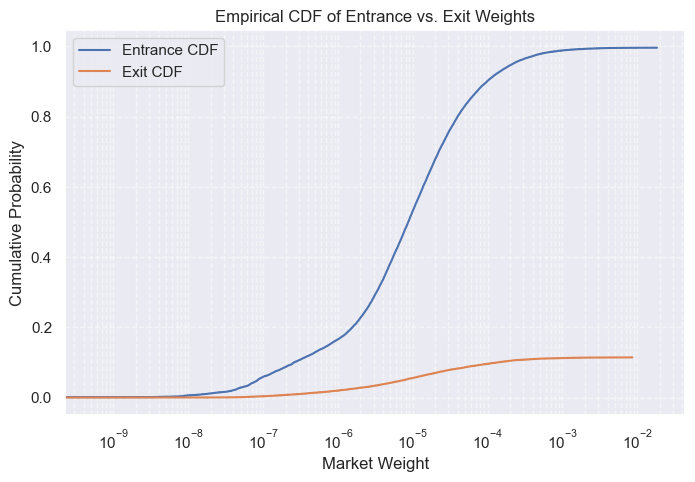

In [23]:
# sort data
x_ent = np.sort(weights_ent)
x_exit = np.sort(weights_exit)


# compute cumulative probabilities
y_ent  = np.arange(1, len(x_ent)+1) / len(x_ent)
y_exit = np.arange(1, len(x_exit)+1) / len(x_exit)

# plot as steps so looks like true cdf
plt.figure(figsize=(8,5))
plt.step(x_ent,  y_ent,  where='post', label='Entrance CDF')
plt.step(x_exit, y_exit, where='post', label='Exit CDF')

plt.xscale('log')

plt.xlabel('Market Weight')
plt.ylabel('Cumulative Probability')
plt.title('Empirical CDF of Entrance vs. Exit Weights')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

In [24]:
print('Entrance mean pctile:', ent_q.mean())
print('Exit mean pctile:', exit_q.mean())

# share in bottom 20% vs top 20% 
for name, series in [('Entrance', ent_q), ('Exit', exit_q)]:
    print(name, 'bottom 20%:', (series <= 0.2).mean(),
          'top 20%:', (series >= 0.8).mean())

Entrance mean pctile: 0.6063426694703852
Exit mean pctile: 0.5700659589593137
Entrance bottom 20%: 0.07435605729121088 top 20%: 0.28079694291298385
Exit bottom 20%: 0.14302884615384615 top 20%: 0.2899639423076923


In [25]:
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

In [26]:
def prepare_beta_data(df_events):
    """
    prep quantile data for Beta distribution fitting bc Beta distribution requires data in [0,1] range
    """
    # separate entrance and exit events
    entrance_data = df_events[df_events['event'] == 'entrance']['quantile'].dropna()
    exit_data = df_events[df_events['event'] == 'exit']['quantile'].dropna()
    
    print(f"Entrance events: {len(entrance_data)}")
    print(f"Exit events: {len(exit_data)}")
    
    return entrance_data, exit_data
# prep the data
entrance_data, exit_data = prepare_beta_data(df_events)

Entrance events: 34281
Exit events: 3328


In [27]:
# fit beta distributions with data adjustment
def fit_beta_distribution(data, event_type):
    """
    Fit beta distribution to quantile data
    Returns parameters and goodness-of-fit statistics
    """
    # handle boundary values
    clean_data = data.dropna()
    
    # Beta distribution requires values strictly between 0 and 1
    # apply small adjustment to boundary values
    epsilon = 1e-6
    clean_data = clean_data.copy()
    clean_data[clean_data <= 0] = epsilon
    clean_data[clean_data >= 1] = 1 - epsilon
    
    print(f"\n{event_type} Data Summary:")
    print(f"Original range: [{data.min():.6f}, {data.max():.6f}]")
    print(f"Adjusted range: [{clean_data.min():.6f}, {clean_data.max():.6f}]")
    print(f"Number of boundary adjustments: {((data <= 0) | (data >= 1)).sum()}")
    
    # fit beta distribution using method of moments and MLE
    alpha_hat, beta_hat, loc, scale = stats.beta.fit(clean_data, floc=0, fscale=1)
    
    # calc goodness of fit using adjusted data
    ks_stat, ks_pvalue = stats.kstest(clean_data, lambda x: stats.beta.cdf(x, alpha_hat, beta_hat))
    
    # calc aic, bic
    log_likelihood = np.sum(stats.beta.logpdf(clean_data, alpha_hat, beta_hat))
    n = len(clean_data)
    aic = 2 * 2 - 2 * log_likelihood  # 2 parameters (alpha, beta)
    bic = np.log(n) * 2 - 2 * log_likelihood
    
    results = {
        'alpha': alpha_hat,
        'beta': beta_hat,
        'ks_statistic': ks_stat,
        'ks_pvalue': ks_pvalue,
        'aic': aic,
        'bic': bic,
        'log_likelihood': log_likelihood,
        'n_observations': n,
        'adjusted_data': clean_data  # Store the adjusted data for later use
    }
    
    print(f"\n{event_type} Beta Distribution Parameters:")
    print(f"Alpha: {alpha_hat:.4f}")
    print(f"Beta: {beta_hat:.4f}")
    print(f"KS Test p-value: {ks_pvalue:.4f}")
    print(f"AIC: {aic:.2f}")
    print(f"BIC: {bic:.2f}")
    
    return results

# fit distributions
entrance_params = fit_beta_distribution(entrance_data, "ENTRANCE")
exit_params = fit_beta_distribution(exit_data, "EXIT")


ENTRANCE Data Summary:
Original range: [0.001852, 1.000000]
Adjusted range: [0.001852, 0.999999]
Number of boundary adjustments: 21

ENTRANCE Beta Distribution Parameters:
Alpha: 1.4299
Beta: 0.8879
KS Test p-value: 0.0000
AIC: -6193.54
BIC: -6176.66

EXIT Data Summary:
Original range: [0.002171, 1.000000]
Adjusted range: [0.002171, 0.999999]
Number of boundary adjustments: 3

EXIT Beta Distribution Parameters:
Alpha: 0.9790
Beta: 0.6926
KS Test p-value: 0.0000
AIC: -472.10
BIC: -459.88


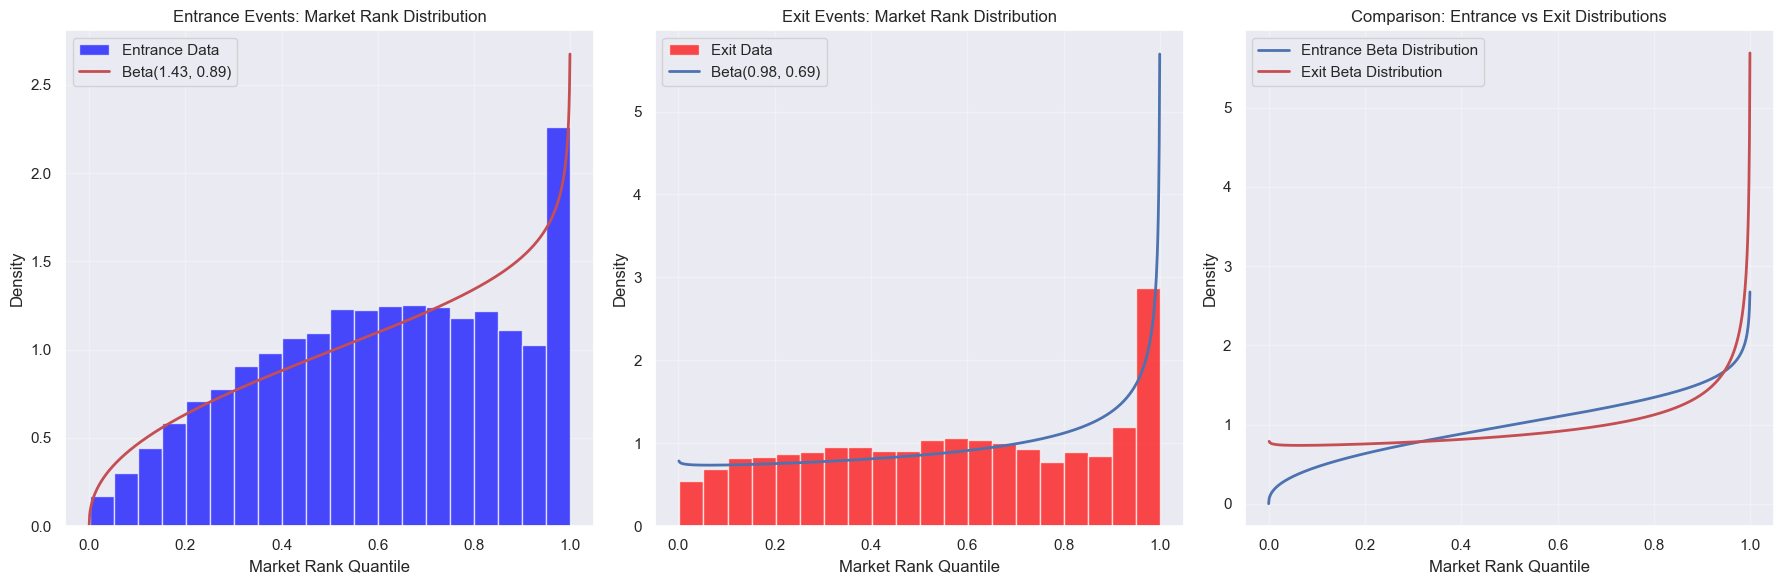

In [28]:
# create basic distribution plots using adjusted data
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# plot setup
x = np.linspace(0, 1, 1000)

# use adjusted data for plotting
entrance_data_adj = entrance_params['adjusted_data']
exit_data_adj = exit_params['adjusted_data']

# entrance distribution
axes[0].hist(entrance_data_adj, bins=20, alpha=0.7, density=True, color='blue', label='Entrance Data')
axes[0].plot(x, stats.beta.pdf(x, entrance_params['alpha'], entrance_params['beta']), 
           'r-', linewidth=2, label=f'Beta({entrance_params["alpha"]:.2f}, {entrance_params["beta"]:.2f})')
axes[0].set_title('Entrance Events: Market Rank Distribution')
axes[0].set_xlabel('Market Rank Quantile')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# exit distribution
axes[1].hist(exit_data_adj, bins=20, alpha=0.7, density=True, color='red', label='Exit Data')
axes[1].plot(x, stats.beta.pdf(x, exit_params['alpha'], exit_params['beta']), 
           'b-', linewidth=2, label=f'Beta({exit_params["alpha"]:.2f}, {exit_params["beta"]:.2f})')
axes[1].set_title('Exit Events: Market Rank Distribution')
axes[1].set_xlabel('Market Rank Quantile')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# comparison plot
axes[2].plot(x, stats.beta.pdf(x, entrance_params['alpha'], entrance_params['beta']), 
           'b-', linewidth=2, label='Entrance Beta Distribution')
axes[2].plot(x, stats.beta.pdf(x, exit_params['alpha'], exit_params['beta']), 
           'r-', linewidth=2, label='Exit Beta Distribution')
axes[2].set_title('Comparison: Entrance vs Exit Distributions')
axes[2].set_xlabel('Market Rank Quantile')
axes[2].set_ylabel('Density')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

out_path = out_dir / "beta.pdf"

#plt.title('Entrance vs Exit Quantiles')
plt.savefig(out_path, bbox_inches="tight")
plt.tight_layout()
plt.show()

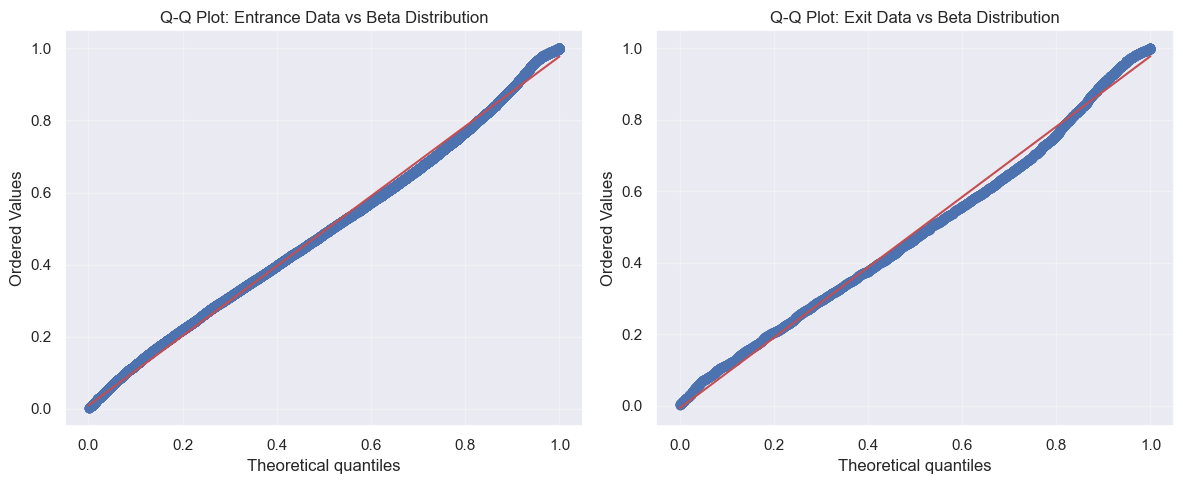

In [29]:
#Q-Q plots for goodness of fit using adjusted data
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Use adjusted data
entrance_data_adj = entrance_params['adjusted_data']
exit_data_adj = exit_params['adjusted_data']

# Q-Q plot for entrance
stats.probplot(entrance_data_adj, dist=stats.beta, sparams=(entrance_params['alpha'], entrance_params['beta']), plot=axes[0])
axes[0].set_title('Q-Q Plot: Entrance Data vs Beta Distribution')
axes[0].grid(True, alpha=0.3)

# Q-Q plot for exit
stats.probplot(exit_data_adj, dist=stats.beta, sparams=(exit_params['alpha'], exit_params['beta']), plot=axes[1])
axes[1].set_title('Q-Q Plot: Exit Data vs Beta Distribution')
axes[1].grid(True, alpha=0.3)

plt.savefig('images/qq.pdf')
plt.tight_layout()
plt.show()

In [30]:
# calculate probabilities by market rank deciles
def calculate_entry_exit_probabilities(entrance_params, exit_params, quantile_range=None):
    """
    Calculate probabilities of entry/exit for different market rank ranges
    """
    if quantile_range is None:
        quantile_range = np.linspace(0, 1, 11)  # Deciles
    
    results = []
    
    for i in range(len(quantile_range)-1):
        lower = quantile_range[i]
        upper = quantile_range[i+1]
        
        # calculate probabilities using CDF
        entrance_prob = (stats.beta.cdf(upper, entrance_params['alpha'], entrance_params['beta']) - 
                        stats.beta.cdf(lower, entrance_params['alpha'], entrance_params['beta']))
        
        exit_prob = (stats.beta.cdf(upper, exit_params['alpha'], exit_params['beta']) - 
                    stats.beta.cdf(lower, exit_params['alpha'], exit_params['beta']))
        
        results.append({
            'quantile_range': f"{lower:.1f}-{upper:.1f}",
            'entrance_probability': entrance_prob,
            'exit_probability': exit_prob,
            'ratio_exit_to_entrance': exit_prob / entrance_prob if entrance_prob > 0 else np.inf
        })
    
    return pd.DataFrame(results)

# calculate probabilities
prob_df = calculate_entry_exit_probabilities(entrance_params, exit_params)
print("PROBABILITY ANALYSIS BY MARKET RANK DECILE:")
print(prob_df.round(4))

PROBABILITY ANALYSIS BY MARKET RANK DECILE:
  quantile_range  entrance_probability  exit_probability  \
0        0.0-0.1                0.0323            0.0742   
1        0.1-0.2                0.0554            0.0746   
2        0.2-0.3                0.0701            0.0767   
3        0.3-0.4                0.0824            0.0795   
4        0.4-0.5                0.0936            0.0833   
5        0.5-0.6                0.1044            0.0882   
6        0.6-0.7                0.1154            0.0951   
7        0.7-0.8                0.1275            0.1052   
8        0.8-0.9                0.1427            0.1234   
9        0.9-1.0                0.1762            0.1998   

   ratio_exit_to_entrance  
0                  2.2972  
1                  1.3468  
2                  1.0929  
3                  0.9649  
4                  0.8899  
5                  0.8454  
6                  0.8238  
7                  0.8254  
8                  0.8649  
9              

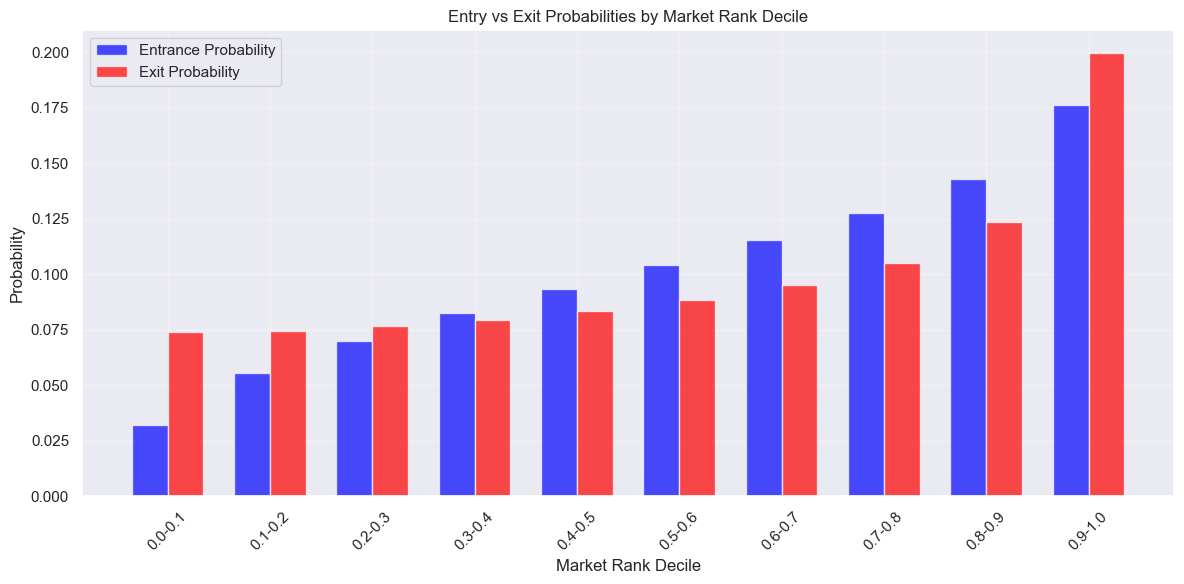

In [31]:
# visualize probability analysis
fig, ax = plt.subplots(figsize=(12, 6))

# Probability comparison by decile
deciles = range(len(prob_df))
width = 0.35

ax.bar([x - width/2 for x in deciles], prob_df['entrance_probability'], 
           width, label='Entrance Probability', alpha=0.7, color='blue')
ax.bar([x + width/2 for x in deciles], prob_df['exit_probability'], 
           width, label='Exit Probability', alpha=0.7, color='red')
ax.set_xlabel('Market Rank Decile')
ax.set_ylabel('Probability')
ax.set_title('Entry vs Exit Probabilities by Market Rank Decile')
ax.set_xticks(deciles)
ax.set_xticklabels(prob_df['quantile_range'], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
# statistical tests to compare distributions
def compare_distributions(entrance_data, exit_data):
    # Kolmogorov-Smirnov test
    ks_stat, ks_pvalue = stats.ks_2samp(entrance_data, exit_data)
    
    # Mann-Whitney U test
    mw_stat, mw_pvalue = stats.mannwhitneyu(entrance_data, exit_data, alternative='two-sided')
    
    # Anderson-Darling test
    try:
        ad_stat, ad_critical, ad_significance = stats.anderson_ksamp([entrance_data, exit_data])
    except:
        ad_stat, ad_significance = np.nan, np.nan
    
    print("STATISTICAL COMPARISON OF ENTRANCE vs EXIT DISTRIBUTIONS:")
    print(f"Kolmogorov-Smirnov Test: max vertical distance={ks_stat:.4f}, p-value={ks_pvalue:.4f}")
    print(f"Mann-Whitney U Test: statistic={mw_stat:.0f}, p-value={mw_pvalue:.4f}")
    if not np.isnan(ad_stat):
        print(f"Anderson-Darling Test: statistic={ad_stat:.4f}, significance={ad_significance:.4f}")
    
    return {
        'ks_statistic': ks_stat,
        'ks_pvalue': ks_pvalue,
        'mw_statistic': mw_stat,
        'mw_pvalue': mw_pvalue,
        'ad_statistic': ad_stat,
        'ad_significance': ad_significance
    }

# Run statistical comparison
comparison_stats = compare_distributions(entrance_data, exit_data)


STATISTICAL COMPARISON OF ENTRANCE vs EXIT DISTRIBUTIONS:
Kolmogorov-Smirnov Test: max vertical distance=0.0859, p-value=0.0000
Mann-Whitney U Test: statistic=60600794, p-value=0.0000
Anderson-Darling Test: statistic=81.9627, significance=0.0010


In [33]:
# summary statistics and interpretation
print("\nSUMMARY STATISTICS:")
print("="*50)

print(f"\nENTRANCE DISTRIBUTION:")
print(f"Alpha: {entrance_params['alpha']:.4f}")
print(f"Beta: {entrance_params['beta']:.4f}")
print(f"Mean: {entrance_params['alpha']/(entrance_params['alpha']+entrance_params['beta']):.4f}")
print(f"Variance: {(entrance_params['alpha']*entrance_params['beta'])/((entrance_params['alpha']+entrance_params['beta'])**2*(entrance_params['alpha']+entrance_params['beta']+1)):.4f}")

if entrance_params['alpha'] > 1 and entrance_params['beta'] > 1:
    mode_entrance = (entrance_params['alpha']-1)/(entrance_params['alpha']+entrance_params['beta']-2)
    print(f"Mode: {mode_entrance:.4f}")

print(f"\nEXIT DISTRIBUTION:")
print(f"Alpha: {exit_params['alpha']:.4f}")
print(f"Beta: {exit_params['beta']:.4f}")
print(f"Mean: {exit_params['alpha']/(exit_params['alpha']+exit_params['beta']):.4f}")
print(f"Variance: {(exit_params['alpha']*exit_params['beta'])/((exit_params['alpha']+exit_params['beta'])**2*(exit_params['alpha']+exit_params['beta']+1)):.4f}")

if exit_params['alpha'] > 1 and exit_params['beta'] > 1:
    mode_exit = (exit_params['alpha']-1)/(exit_params['alpha']+exit_params['beta']-2)
    print(f"Mode: {mode_exit:.4f}")

print(f"\nINTERPRETATION:")
print("="*50)
if entrance_params['alpha'] > entrance_params['beta']:
    print("• Entrance: Firms tend to enter at HIGHER market ranks (top of market)")
else:
    print("• Entrance: Firms tend to enter at LOWER market ranks (bottom of market)")
    
if exit_params['alpha'] > exit_params['beta']:
    print("• Exit: Firms tend to exit at HIGHER market ranks (top of market)")
else:
    print("• Exit: Firms tend to exit at LOWER market ranks (bottom of market)")

print(f"\n• Statistical significance (KS test): {'SIGNIFICANT' if comparison_stats['ks_pvalue'] < 0.05 else 'NOT SIGNIFICANT'} (p={comparison_stats['ks_pvalue']:.4f})")



SUMMARY STATISTICS:

ENTRANCE DISTRIBUTION:
Alpha: 1.4299
Beta: 0.8879
Mean: 0.6169
Variance: 0.0712

EXIT DISTRIBUTION:
Alpha: 0.9790
Beta: 0.6926
Mean: 0.5857
Variance: 0.0908

INTERPRETATION:
• Entrance: Firms tend to enter at HIGHER market ranks (top of market)
• Exit: Firms tend to exit at HIGHER market ranks (top of market)

• Statistical significance (KS test): SIGNIFICANT (p=0.0000)


In [34]:
# entrance (birth) density
α_b, β_b = entrance_params['alpha'], entrance_params['beta']
pdf_birth = lambda x: beta.pdf(x, α_b, β_b, loc=0, scale=1)

# exit (death) density
α_d, β_d = exit_params['alpha'], exit_params['beta']
pdf_death = lambda x: beta.pdf(x, α_d, β_d, loc=0, scale=1)

In [35]:
import numpy as np
from scipy.stats import beta
pdf_birth(0.5)  # ≈ f_birth(50th percentile)
pdf_death(0.5)  # ≈ f_death(50th percentile)

np.float64(0.8553644239320007)

In [36]:
α_b, β_b = entrance_params['alpha'], entrance_params['beta']
α_d, β_d = exit_params['alpha'],     exit_params['beta']

# define rank-dependent pdfs
pdf_birth = lambda x: beta.pdf(x, α_b, β_b, loc=0, scale=1)
pdf_death = lambda x: beta.pdf(x, α_d, β_d, loc=0, scale=1)

ratio = num_entrances / num_exits if num_exits > 0 else np.inf

λ_death_pf = 1.0
λ_birth_pf = ratio * λ_death_pf


print(f"λ_birth_pf = {λ_birth_pf:.6f}, λ_death_pf = {λ_death_pf:.6f}")

# rank‐dependent intensities thru multiplying by the pdf of birth and death from beta dist
λ_birth = lambda x: λ_birth_pf * pdf_birth(x)
λ_death = lambda x: λ_death_pf * pdf_death(x)
λ_total = lambda x: λ_birth(x) + λ_death(x)

# start with the empirical percentiles at the first month
raw = msf.loc[msf['month'] == first_month, 'pctile']
clean = raw.dropna().values
# clamp them so none are exactly 0 or 1
# thought this was already done but having an issue getting nan so...
particles = np.clip(clean, 1e-6, 1-1e-6)

print("Seeded particle count:", particles.size)

def safe_pdf(x, α, β, eps=1e-6):
    x = np.clip(x, eps, 1-eps)
    return beta.pdf(x, α, β, loc=0, scale=1)

pdf_birth  = lambda x: safe_pdf(x, α_b, β_b)
pdf_death  = lambda x: safe_pdf(x, α_d, β_d)
λ_birth    = lambda x: λ_birth_pf * pdf_birth(x)
λ_death    = lambda x: λ_death_pf * pdf_death(x)
λ_total    = lambda x: λ_birth(x) + λ_death(x)
# confirmed thru testing atp that they're not nan! 

# assuming `particles` is (clamped) array of starting percentiles
birth_rates = λ_birth(particles)
death_rates = λ_death(particles)


nan_idx = np.where(np.isnan(birth_rates))[0]
total_rates = λ_total(particles)

NameError: name 'num_exits' is not defined

In [37]:
α_b, β_b = entrance_params['alpha'], entrance_params['beta']
α_d, β_d = exit_params['alpha'],     exit_params['beta']

# define rank-dependent pdfs
pdf_birth = lambda x: beta.pdf(x, α_b, β_b, loc=0, scale=1)
pdf_death = lambda x: beta.pdf(x, α_d, β_d, loc=0, scale=1)

first_month = df_events['month'].min()
last_month  = df_events['month'].max()
T_months    = (last_month - first_month).n + 1 # total number of months in sample span

monthly_counts = msf.groupby('month')['permno'].nunique() # number of distinct firms trading each month
avg_n = monthly_counts.mean()

num_entrances = df_ent.shape[0] # total count of entrance rows, same for exit next line
num_exits     = df_exit.shape[0]

# per firm probabilities
# num_entrances / T_months = average num of entrances per month across sample
# / avg_n converts to a per firm probability
# just the same for each firm?
p_birth_per_firm = (num_entrances / T_months) / avg_n  
p_death_per_firm = (num_exits     / T_months) / avg_n  

# convert from interval probability to instantaneous rates
#λ_birth_pf = -np.log(1 - p_birth_per_firm)
#λ_death_pf = -np.log(1 - p_death_per_firm)

λ_birth_pf = 10
λ_death_pf = 1


print(f"λ_birth_pf = {λ_birth_pf:.6f}, λ_death_pf = {λ_death_pf:.6f}")

# rank‐dependent intensities thru multiplying by the pdf of birth and death from beta dist
λ_birth = lambda x: λ_birth_pf * pdf_birth(x)
λ_death = lambda x: λ_death_pf * pdf_death(x)
λ_total = lambda x: λ_birth(x) + λ_death(x)

# start with the empirical percentiles at the first month
raw = msf.loc[msf['month'] == first_month, 'pctile']
clean = raw.dropna().values
# clamp them so none are exactly 0 or 1
# thought this was already done but having an issue getting nan so...
particles = np.clip(clean, 1e-6, 1-1e-6)

print("Seeded particle count:", particles.size)

def safe_pdf(x, α, β, eps=1e-6):
    x = np.clip(x, eps, 1-eps)
    return beta.pdf(x, α, β, loc=0, scale=1)

pdf_birth  = lambda x: safe_pdf(x, α_b, β_b)
pdf_death  = lambda x: safe_pdf(x, α_d, β_d)
λ_birth    = lambda x: λ_birth_pf * pdf_birth(x)
λ_death    = lambda x: λ_death_pf * pdf_death(x)
λ_total    = lambda x: λ_birth(x) + λ_death(x)
# confirmed thru testing atp that they're not nan! 

# assuming `particles` is (clamped) array of starting percentiles
birth_rates = λ_birth(particles)
death_rates = λ_death(particles)


nan_idx = np.where(np.isnan(birth_rates))[0]
total_rates = λ_total(particles)

print("birth_rates shape:", birth_rates.shape)
print("  sample:", birth_rates[:5])
print("death_rates shape:", death_rates.shape)
print("  sample:", death_rates[:5])
print("total_rates shape:", total_rates.shape)
print("  sample:", total_rates[:5])

# quick summary statistics
print("birth: min/mean/max =", birth_rates.min(), birth_rates.mean(), birth_rates.max())
print("death: min/mean/max =", death_rates.min(), death_rates.mean(), death_rates.max())
print("total: min/mean/max =", total_rates.min(), total_rates.mean(), total_rates.max())

λ_birth_pf = 10.000000, λ_death_pf = 1.000000
Seeded particle count: 506
birth_rates shape: (506,)
  sample: [ 6.44287845 15.65841638 11.00959821  8.53874022  9.06661787]
death_rates shape: (506,)
  sample: [0.75627334 1.4562155  0.91445764 0.80366848 0.82136814]
total_rates shape: (506,)
  sample: [ 7.19915179 17.11463188 11.92405586  9.3424087   9.88798601]
birth: min/mean/max = 0.8491746228030785 10.084061831069512 58.035600120869894
death: min/mean/max = 0.7365082406267903 1.0848857789944575 47.601487895910296
total: min/mean/max = 1.6259502285791099 11.16894761006397 105.63708801678018


In [38]:
# simulation horizon, in month units bc lambdas are per month
T_sim = 300  # 300 months ~ 25 years

t = 0.0
i = 0
events = []  # to record (type, time, x)

# main loop - one Exp clock per particle
#while t < T_sim and len(particles) > 0:
while i < 10000:  
    # compute each particle’s total intensity
    i +=1 # counting loop iterations to make sure it doesn't just stop at 1
    rates = λ_total(particles)         # vector of λ_i
    # pull waiting times ~ Exp(λ_i)
    taus = np.random.exponential(1.0 / rates)
    
    # find next event
    i_star = np.argmin(taus)
    dt = taus[i_star]
    t += dt
    x_i = particles[i_star]
    
    # pick birth vs death
    if np.random.rand() < λ_birth(x_i) / λ_total(x_i):
        # birth: add a new particle at the same percentile
        particles = np.append(particles, x_i)
        particles = np.clip(particles, 1e-6, 1-1e-6)
        events.append(('birth', t, x_i))
    else:
        # death: remove that particle
        events.append(('death', t, x_i))
        particles = np.delete(particles, i_star)
#print("Loop iterations:", i)
#print("Events recorded:", len(events))

Total events: 10000
Birth events: 9046
Death events: 954


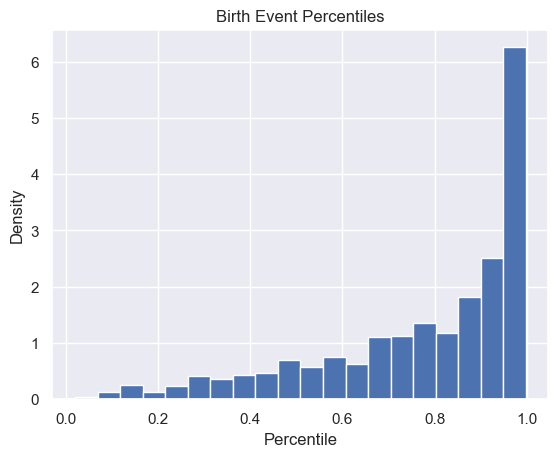

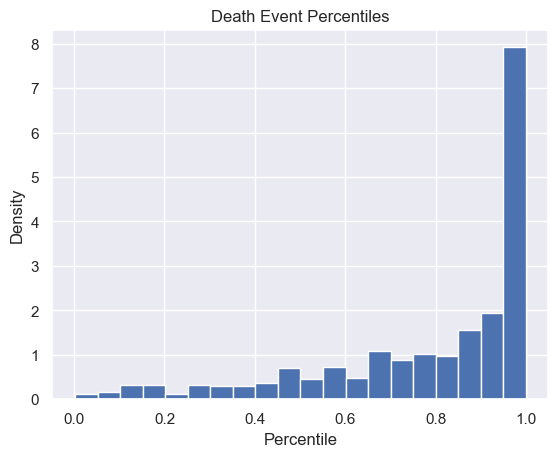

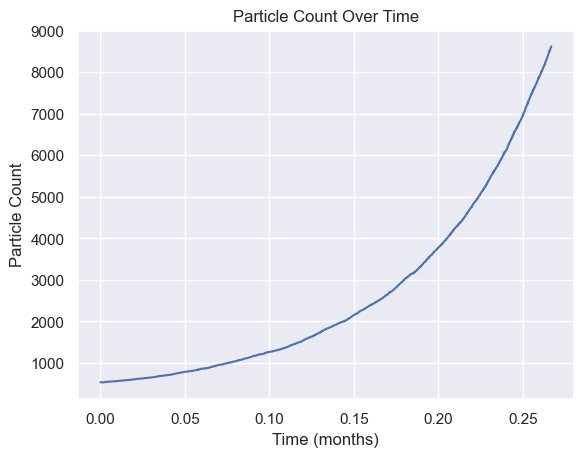

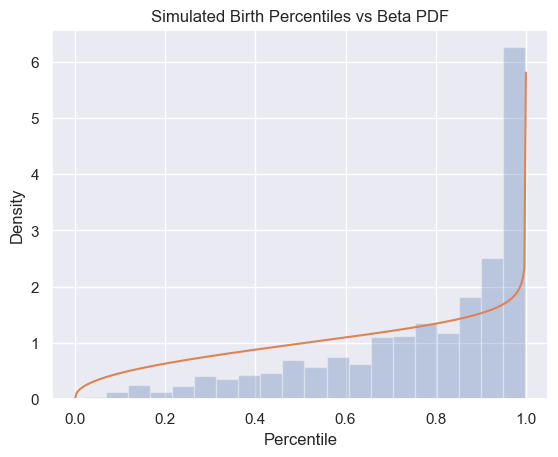

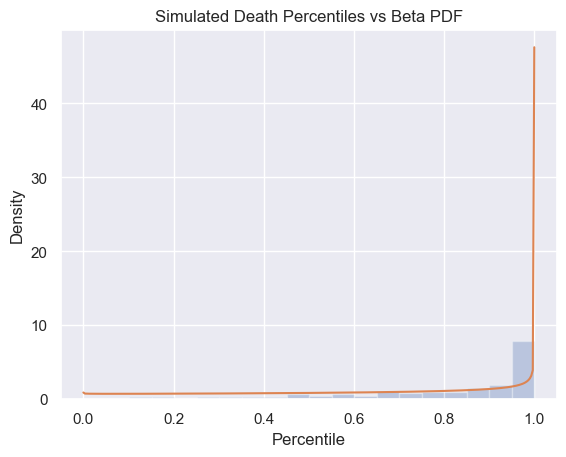

In [39]:
df_sim = pd.DataFrame(events, columns=['event', 'time', 'percentile'])
counts = df_sim['event'].value_counts()
print("Total events:", len(df_sim))
print("Birth events:", counts.get('birth', 0))
print("Death events:", counts.get('death', 0))

plt.figure()
plt.hist(df_sim[df_sim['event']=='birth']['percentile'], bins=20, density=True)
plt.title('Birth Event Percentiles')
plt.xlabel('Percentile')
plt.ylabel('Density')
plt.savefig('images/birthp.pdf')
plt.show()

plt.figure()
plt.hist(df_sim[df_sim['event']=='death']['percentile'], bins=20, density=True)
plt.title('Death Event Percentiles')
plt.xlabel('Percentile')
plt.ylabel('Density')
out_path = out_dir / "death.pdf"

#plt.title('Entrance vs Exit Quantiles')
plt.savefig(out_path, bbox_inches="tight")
plt.show()

particle_counts = [raw.size]
times = [0.0]
count = raw.size
for etype, time_, _ in events:
    count += 1 if etype == 'birth' else -1
    times.append(time_)
    particle_counts.append(count)

plt.figure()
plt.plot(times, particle_counts)
plt.title('Particle Count Over Time')
plt.xlabel('Time (months)')
plt.ylabel('Particle Count')
out_path1 = out_dir / "birth.pdf"

#plt.title('Entrance vs Exit Quantiles')
plt.savefig(out_path1, bbox_inches="tight")
plt.show()

x_vals = np.linspace(0, 1, 300)
plt.figure()
plt.hist(df_sim[df_sim['event']=='birth']['percentile'], bins=20, density=True, alpha=0.3)
plt.plot(x_vals, pdf_birth(x_vals))
plt.title('Simulated Birth Percentiles vs Beta PDF')
plt.xlabel('Percentile')
plt.ylabel('Density')
plt.show()

plt.figure()
plt.hist(df_sim[df_sim['event']=='death']['percentile'], bins=20, density=True, alpha=0.3)
plt.plot(x_vals, pdf_death(x_vals))
plt.title('Simulated Death Percentiles vs Beta PDF')
plt.xlabel('Percentile')
plt.ylabel('Density')
plt.show()